Test Model 3 Layer CNN

In [37]:
# Cell 1: Imports
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

# Import your model
import sys
sys.path.append('./code/classifier')  # Adjust path as needed
from models import LargeCNN

print("Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Imports successful!
PyTorch version: 1.10.1+cu102
CUDA available: False


In [40]:
# Cell 2: Load the Trained Model
def load_trained_model(model_path, num_classes=7):
    """Load trained largeCNN model"""
    
    # Create model architecture
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LargeCNN(num_classes=num_classes).to(device)
    
    # Load saved weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set to evaluation mode (disables dropout)
    
    print(f"✓ Model loaded from: {model_path}")
    print(f"✓ Device: {device}")
    print(f"✓ Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    return model, device

# Cell 2 in the notebook:
MODEL_PATH = 'results/large_cnn_20251201_222718/model.pth'

# Load model
model, device = load_trained_model(MODEL_PATH)

✓ Model loaded from: results/large_cnn_20251201_222718/model.pth
✓ Device: cpu
✓ Model parameters: 4,046,215


In [41]:
# Cell 3: Define Preprocessing and Class Names
# Emotion classes (must match training order)
CLASS_NAMES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

class AddGaussianNoise:
    """Add Gaussian noise to simulate grainy images"""
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise
    
    def __repr__(self):
        return f'{self.__class__.__name__}(mean={self.mean}, std={self.std})'

class ReduceQuality:
    """Simulate low-quality image by downsampling and upsampling"""
    def __init__(self, downscale_factor=0.5):
        self.downscale_factor = downscale_factor
    
    def __call__(self, img):
        # Get current size
        w, h = img.size
        
        # Downscale
        small_w = int(w * self.downscale_factor)
        small_h = int(h * self.downscale_factor)
        img_small = img.resize((small_w, small_h), Image.BILINEAR)
        
        # Upscale back (creates blocky artifacts)
        img_degraded = img_small.resize((w, h), Image.BILINEAR)
        
        return img_degraded

class DegradeToTrainingQuality:
    """
    Comprehensive degradation to match training data:
    - Reduce resolution
    - Add noise
    - Reduce contrast
    - Add blur
    - Simulate compression
    """
    def __init__(self, 
                 downscale_factor=0.3,
                 noise_std=0.05,
                 contrast_factor=0.7,
                 blur_sigma=1.0,
                 jpeg_quality=30):
        self.downscale_factor = downscale_factor
        self.noise_std = noise_std
        self.contrast_factor = contrast_factor
        self.blur_sigma = blur_sigma
        self.jpeg_quality = jpeg_quality
    
    def __call__(self, img):
        """Apply all degradation steps"""
        
        # 1. Reduce contrast (makes image flatter)
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(self.contrast_factor)
        
        # 2. Downscale and upscale (creates blocky artifacts)
        w, h = img.size
        small_size = (int(w * self.downscale_factor), int(h * self.downscale_factor))
        img = img.resize(small_size, Image.BILINEAR)
        img = img.resize((w, h), Image.BILINEAR)
        
        # 3. Add slight blur
        img = img.filter(ImageFilter.GaussianBlur(radius=self.blur_sigma))
        
        # 4. Simulate JPEG compression artifacts
        import io
        buffer = io.BytesIO()
        img.save(buffer, format='JPEG', quality=self.jpeg_quality)
        buffer.seek(0)
        img = Image.open(buffer)
        
        return img
        
# Preprocessing pipeline (MUST match training)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

print("Preprocessing pipeline created")
print(f"Classes: {CLASS_NAMES}")

Preprocessing pipeline created
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [42]:
# Cell 4: Single Image Prediction Function
def predict_emotion(image_path, model, device, transform, class_names):
    """
    Predict emotion from a single image
    
    Args:
        image_path: Path to image file
        model: Trained model
        device: torch device
        transform: Preprocessing transforms
        class_names: List of emotion names
    
    Returns:
        predicted_class: Predicted emotion name
        confidence: Confidence score (0-1)
        all_probs: Probabilities for all classes
    """
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')  # Ensure RGB
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    
    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted_idx = torch.max(probabilities, dim=1)
        
    predicted_class = class_names[predicted_idx.item()]
    confidence_score = confidence.item()
    all_probs = probabilities[0].cpu().numpy()
    
    return predicted_class, confidence_score, all_probs

# Test the function
print("Prediction function defined")

Prediction function defined


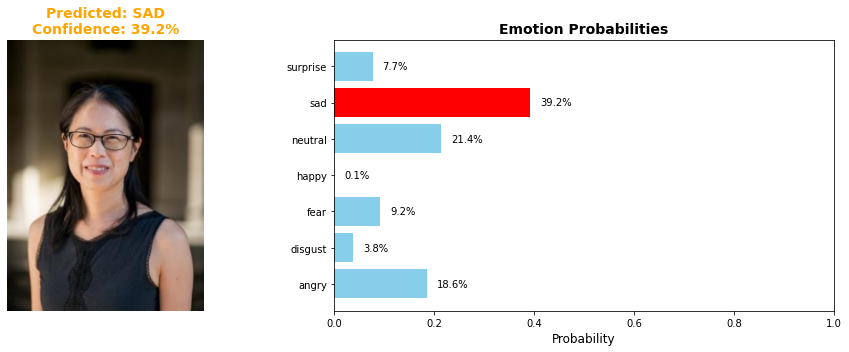


Image: chen.jpeg
Predicted Emotion: sad
Confidence: 39.18%

All Probabilities:
  angry     : 18.62%
  disgust   :  3.78%
  fear      :  9.23%
  happy     :  0.06%
  neutral   : 21.44%
  sad       : 39.18%
  surprise  :  7.69%



In [46]:
# Cell 5: Visualize Single Prediction
def visualize_prediction(image_path, model, device, transform, class_names):
    """Visualize image with prediction and probability distribution"""
    
    # Get prediction
    pred_class, confidence, all_probs = predict_emotion(
        image_path, model, device, transform, class_names
    )
    
    # Load original image for display
    original_image = Image.open(image_path)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Display image
    ax1.imshow(original_image, cmap='gray' if original_image.mode == 'L' else None)
    ax1.set_title(f'Predicted: {pred_class.upper()}\nConfidence: {confidence*100:.1f}%', 
                  fontsize=14, fontweight='bold', 
                  color='green' if confidence > 0.7 else 'orange')
    ax1.axis('off')
    
    # Display probability distribution
    colors = ['red' if prob == max(all_probs) else 'skyblue' for prob in all_probs]
    bars = ax2.barh(class_names, all_probs, color=colors)
    ax2.set_xlabel('Probability', fontsize=12)
    ax2.set_title('Emotion Probabilities', fontsize=14, fontweight='bold')
    ax2.set_xlim([0, 1])
    
    # Add percentage labels on bars
    for i, (bar, prob) in enumerate(zip(bars, all_probs)):
        ax2.text(prob + 0.02, i, f'{prob*100:.1f}%', 
                va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"\n{'='*50}")
    print(f"Image: {os.path.basename(image_path)}")
    print(f"Predicted Emotion: {pred_class}")
    print(f"Confidence: {confidence*100:.2f}%")
    print(f"\nAll Probabilities:")
    for name, prob in zip(class_names, all_probs):
        print(f"  {name:10s}: {prob*100:5.2f}%")
    print(f"{'='*50}\n")

# Test on a single image
TEST_IMAGE = '../../TestData/FunTests/chen.jpeg'
visualize_prediction(TEST_IMAGE, model, device, transform_match_training, CLASS_NAMES)

In [ ]:
# Cell 7: Test on Entire Test Dataset
def evaluate_test_set(test_folder, model, device, transform, class_names):
    """Evaluate model on entire test dataset"""
    
    from torch.utils.data import DataLoader
    from torchvision import datasets
    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns
    
    # Load test dataset
    test_dataset = datasets.ImageFolder(test_folder, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    print(f"Test dataset: {len(test_dataset)} images")
    print(f"Classes: {test_dataset.classes}\n")
    
    # Evaluate
    all_preds = []
    all_labels = []
    all_probs = []
    
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate metrics
    accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    
    print(f"{'='*60}")
    print(f"TEST SET RESULTS")
    print(f"{'='*60}")
    print(f"Overall Accuracy: {accuracy:.2f}%\n")
    
    # Classification report
    print("Per-Class Performance:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Test Set Confusion Matrix\nOverall Accuracy: {accuracy:.2f}%', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return accuracy, all_preds, all_labels, all_probs

# Run evaluation
TEST_DATASET_FOLDER = '../../TestData/images/test'  # UPDATE THIS!
if os.path.exists(TEST_DATASET_FOLDER):
    accuracy, preds, labels, probs = evaluate_test_set(
        TEST_DATASET_FOLDER, model, device, transform, CLASS_NAMES
    )
else:
    print(f"Test folder not found: {TEST_DATASET_FOLDER}")

In [ ]:
# Cell 8: Find Misclassified Examples
def find_errors(test_folder, model, device, transform, class_names, n_examples=9):
    """Find and display misclassified examples"""
    
    from torchvision import datasets
    
    # Load dataset
    test_dataset = datasets.ImageFolder(test_folder, transform=transform)
    
    # Find misclassifications
    errors = []
    model.eval()
    
    for idx in range(len(test_dataset)):
        image_tensor, true_label = test_dataset[idx]
        image_path = test_dataset.samples[idx][0]
        
        # Predict
        with torch.no_grad():
            output = model(image_tensor.unsqueeze(0).to(device))
            probs = torch.softmax(output, dim=1)
            pred_idx = torch.argmax(output, dim=1).item()
            confidence = probs[0][pred_idx].item()
        
        # Check if wrong
        if pred_idx != true_label:
            errors.append({
                'path': image_path,
                'true': class_names[true_label],
                'pred': class_names[pred_idx],
                'confidence': confidence
            })
    
    print(f"Found {len(errors)} misclassifications out of {len(test_dataset)} images")
    print(f"Error rate: {100*len(errors)/len(test_dataset):.2f}%\n")
    
    # Display some errors
    if errors:
        n_show = min(n_examples, len(errors))
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        axes = axes.flatten()
        
        for idx in range(n_show):
            error = errors[idx]
            image = Image.open(error['path'])
            
            axes[idx].imshow(image, cmap='gray' if image.mode == 'L' else None)
            axes[idx].set_title(
                f"True: {error['true']}\n"
                f"Predicted: {error['pred']}\n"
                f"Confidence: {error['confidence']*100:.1f}%",
                fontsize=11, color='red', fontweight='bold'
            )
            axes[idx].axis('off')
        
        # Hide unused
        for idx in range(n_show, 9):
            axes[idx].axis('off')
        
        plt.suptitle('Misclassified Examples', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Show most confident errors
        errors_sorted = sorted(errors, key=lambda x: x['confidence'], reverse=True)
        print("\nMost Confident Mistakes (Top 10):")
        print(f"{'True':<12} {'Predicted':<12} {'Confidence'}")
        print("-" * 40)
        for error in errors_sorted[:10]:
            print(f"{error['true']:<12} {error['pred']:<12} {error['confidence']*100:>5.1f}%")

# Find errors
if os.path.exists(TEST_DATASET_FOLDER):
    find_errors(TEST_DATASET_FOLDER, model, device, transform, CLASS_NAMES)